In [8]:
## Include packages

using DelimitedFiles
using DCAUtils
using PyPlot
using Statistics
using KitMSA
using FastaIO
using LinearAlgebra
using StatsBase
using JLD2

include("../src/read_write.jl")
include("../src/energy.jl")
include("../src/msa_tools.jl")
include("../src/extra_tools.jl")
include("../src/mutability.jl")
;

In [9]:
function write_cde_of_chains(folder, out_path, mask, h, J, n)
    fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder))
    res = []
    for i in 1:n
        chain = Int8.(fasta2matrix(joinpath(folder_path, fasta_files[i])))[mask,:]
        cde_msa = hcat([cont_dep_entr_without_deg(chain[step,:], h, J) 
                for step in 1:length(chain[:,1])]...)'
        push!(res, vec(cde_msa))
        if i %10 == 0
            println(i)
        end
    end
    writedlm(out_path, hcat(res...))
    #return hcat(res...)
end


function read_par_BM_standardorder(path::AbstractString, q::Integer = 21)
    params = readdlm(path,' ', use_mmap = true)[:, 2:6]
    l_file = size(params, 1)
    N = Integer(((q - 2) + sqrt( (q-2)^2 + 8*l_file))/(2*q))
    J = Array{Float64}(undef, q, q, N, N)
    h = Array{Float64}(undef, q, N)
    n_J = Int(q*q*N*(N-1)/2)
    n_h = q*N
    for k in 1:n_J
        i, j, a, b, par_j = params[k, :]
        i += 1
        j += 1
        a += 1
        b += 1
        J[a, b, i, j] = par_j
    end
    for l in (n_J + 1): n_h + n_J
        i, a, par_h = params[l, :]
        i += 1
        a += 1
        h[a, i] = par_h
    end
    return h, J
end

function read_par_BM_save(path::AbstractString, q::Integer = 21)    
    params = readdlm(path,' ', use_mmap = true)[:, 2:6]
    l_file = size(params, 1) 
    N = Integer(((q - 2) + sqrt( (q-2)^2 + 8*l_file))/(2*q))
    J = Array{Float64}(undef, q, q, N, N)
    h = Array{Float64}(undef, q, N)
    n_J = Int(q*q*N*(N-1)/2)
    n_h = q*N

    for k in 1:n_J
        i, j, a, b, par_j = params[k, :]
        i += 1
        j += 1
        a == 0 && (a = 21)
        b == 0 && (b = 21)
        J[a, b, i, j] = par_j
    end

    for l in (n_J + 1): n_h + n_J
        i, a, par_h = params[l, :]
        i += 1
        a == 0 && (a = 21)
        h[a, i] = par_h
    end

    return h, J
end

read_par_BM_save (generic function with 2 methods)

In [3]:
using DelimitedFiles

PATH_PAR = "../../DHFR_pars/Parameters_conv_DHFR.dat"
h_new, J_new = read_par_BM_save(PATH_PAR, 21);

In [10]:
@load "../../DHFR_pars/DHFRparams.jld2"

2-element Vector{Symbol}:
 :h
 :J

In [11]:
println(sum(abs2, h))
println(sum(abs2, J))

115699.3872580244
4534.848277649538


In [59]:
sum(abs2, J .- permutedims(J, [2,1,4,3]))

0.0

In [4]:
@load "../../new_pars_DHFR.jld2"

2-element Vector{Symbol}:
 :h
 :J

In [12]:
path_nat = "../../DHFR_pars/PF00186_nogapped.fasta"
#path_nat = "../../Serine_Prot/yaakov_short.faa"
nat_MSA = Int8.(fasta2matrix(path_nat))
;

In [64]:
folder_path = "../../scra_data_beta/amino_mixed_dhfr_hinds_steps4000000_seqs500_T1.0p0.5"
#folder_path = "../../scra_data_beta/amino_mixed_serine_steps450000_seqs100_T1.0p0.5"
fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder_path))
@time matrices = [Int8.(fasta2matrix(joinpath(folder_path, file))) 
    for file in fasta_files]
step_matrices = build_seq_matrices(matrices)
;

  0.194750 seconds (247.51 k allocations: 47.093 MiB, 40.80% compilation time)


## Data for 2B-C-D

In [229]:
start = time()
cde_NAT = []
for i in 1:length(nat_MSA[:,1])
    seq = deepcopy(nat_MSA[i,:])
    push!(cde_NAT, cont_dep_entr_without_deg(seq, h, J))
end
cde_NAT = hcat(cde_NAT...)'
fine = time()
println(fine-start)
#writedlm("../data/figures/data_fig2/cde_NAT", cde_NAT)

145.07905316352844


In [65]:
start_wt = Int.(fasta2matrix("../../DHFR_pars/wt_hinds.fasta")[1,:]);
cde_wt = cont_dep_entr_without_deg(start_wt, h, J);
#writedlm("../data/figures/data_fig2/cde_PSE", cde_pse)

In [15]:
L = length(step_matrices[1][1,:])
freqs_nat = reshape(compute_weighted_frequencies(Int8.(nat_MSA'), 22, 0.2)[1], (21, L))
entr_nat = get_entropy(freqs_nat);

θ = 0.2 threshold = 32.0
M = 36612 N = 160 Meff = 8785.59817623452


In [68]:
freqs = [reshape(compute_weighted_frequencies(Int8.(MSA'),22,0.)[1],(21, L)) 
        for MSA in step_matrices]
entr = [get_entropy(f) for f in freqs];
entr = hcat(entr...)';
#writedlm("../data/figures/data_fig2/evol_entr_betalac", entr)

θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500

In [69]:
cie = entr_nat
epis= [x in sortperm(cie .- cde_wt, rev=true)[1:10] for x in 1:length(cie)]
d_from_neg_bisec = (cde_wt .+ cie .- 2) ./ sqrt(2)
varr = [x in sortperm(d_from_neg_bisec, rev=true)[1:10] for x in 1:length(cie)]
cons = [x in sortperm(d_from_neg_bisec, rev=false)[1:10] for x in 1:length(cie)]
X = [round(Int, n^(3.8)) for n in 1:size(entr,1)];

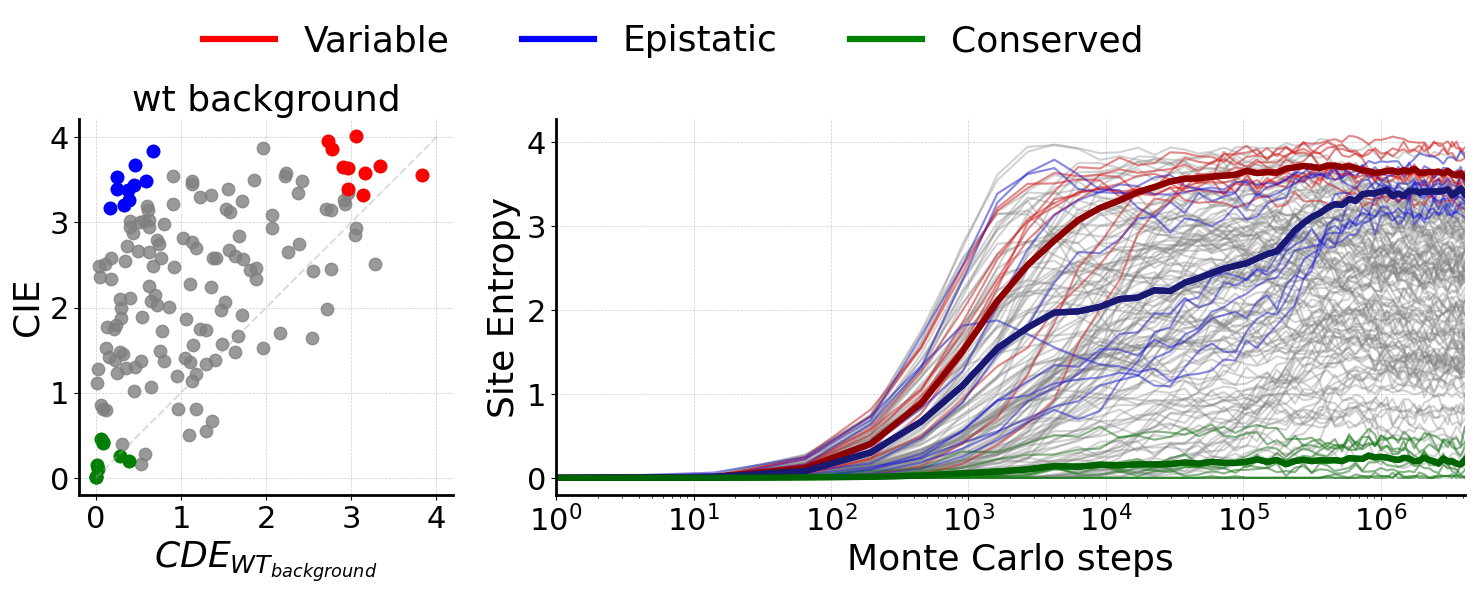

In [70]:

cie = entr_nat
epis= [x in sortperm(cie .- cde_wt, rev=true)[1:10] for x in 1:length(cie)]
d_from_neg_bisec = (cde_wt .+ cie .- 2) ./ sqrt(2)
varr = [x in sortperm(d_from_neg_bisec, rev=true)[1:10] for x in 1:length(cie)]
cons = [x in sortperm(d_from_neg_bisec, rev=false)[1:10] for x in 1:length(cie)]
X = [round(Int, n^(3.8)) for n in 1:size(entr,1)];

pointsize = 80
transp = 0.8
transp2 = 1
lab = [0,1,2,3,4]
lab2 = [10^i for i in 2:7]
axis_width = 2.

ticks_font = 22
axis_font = 26

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(20)
 
ax1 = plt.subplot2grid(shape=(1, 4), loc=(0, 0), colspan = 1)
ax2 = plt.subplot2grid(shape=(1, 4), loc=(0, 1), colspan = 2)

fig.subplots_adjust(wspace=0.2)

ax1.plot([0, 4.0], [0, 4.0], linestyle="--", alpha = 0.4, color = "darkgrey")
ax1.scatter(cde_wt, cie, color = "grey", s = pointsize, alpha = transp)
ax1.scatter(cde_wt[varr], cie[varr], color = "red", s = pointsize, alpha = transp2)
ax1.scatter(cde_wt[epis], cie[epis], color = "blue",  s = pointsize, alpha = transp2)
ax1.scatter(cde_wt[cons], cie[cons], color = "green",  s = pointsize, alpha = transp2)
ax1.set_xlabel("\$CDE_{WT_{background}}\$", fontsize=axis_font)
ax1.set_ylabel("CIE", fontsize=axis_font)
ax1.grid(color = "grey", linestyle = "--", linewidth = 0.5, alpha = 0.4)
ax1.set_xticks([0,1,2,3,4])
ax1.set_yticks([0,1,2,3,4])
ax1.set_xticklabels(lab, fontsize = ticks_font)
ax1.set_yticklabels(lab, fontsize = ticks_font)
ax1.spines["top"].set_visible(false)
ax1.spines["right"].set_visible(false)
ax1.spines["left"].set_linewidth(axis_width)
ax1.spines["bottom"].set_linewidth(axis_width)
ax1.set_aspect("equal")
ax1.set_title("wt background", fontsize = axis_font)

ax2.plot(X, entr, color = "grey", alpha = 0.35)
ax2.plot(X, entr[:, varr], color = "red", alpha = 0.35)
ax2.plot(X, entr[:, epis], color = "blue", alpha = 0.35)
ax2.plot(X, entr[:, cons], color = "green", alpha = 0.35)
ax2.plot(X, mean(entr[:, varr], dims = 2)[:], color = "red", linewidth=4.5, label = "Variable" )
ax2.plot(X, mean(entr[:, epis], dims = 2)[:], color = "blue", linewidth = 4.5, label = "Epistatic")
ax2.plot(X, mean(entr[:, cons], dims = 2)[:], color = "green", linewidth = 4.5, label = "Conserved")
ax2.plot(X, mean(entr[:, varr], dims = 2)[:], color = "darkred", linewidth=4.5 )
ax2.plot(X, mean(entr[:, epis], dims = 2)[:], color = "midnightblue", linewidth = 4.5)
ax2.plot(X, mean(entr[:, cons], dims = 2)[:], color = "darkgreen", linewidth = 4.5)
ax2.set_xlabel("Monte Carlo steps", fontsize=axis_font)
ax2.set_ylabel("Site Entropy", fontsize=axis_font)
ax2.grid(color = "grey", linestyle = "--", linewidth = 0.5, alpha = 0.4)
ax2.set_yticks([0,1,2,3,4])
ax2.set_xticks(lab2)
ax2.set_xticklabels(lab2, fontsize = ticks_font)
ax2.set_yticklabels(lab, fontsize = ticks_font)
ax2.set_xlim(minimum(X),maximum(X))
ax2.spines["top"].set_visible(false)
ax2.spines["right"].set_visible(false)
ax2.spines["left"].set_linewidth(axis_width)
ax2.spines["bottom"].set_linewidth(axis_width)
ax2.set_xscale("log")

tight_layout()
fig.legend(loc="upper right", fontsize = axis_font, frameon = false, ncol = 3, bbox_to_anchor=(0.6, 1.2))
#savefig("../Serin_Prot_dynamics.png")
savefig("../dhfr_dynamics.png")

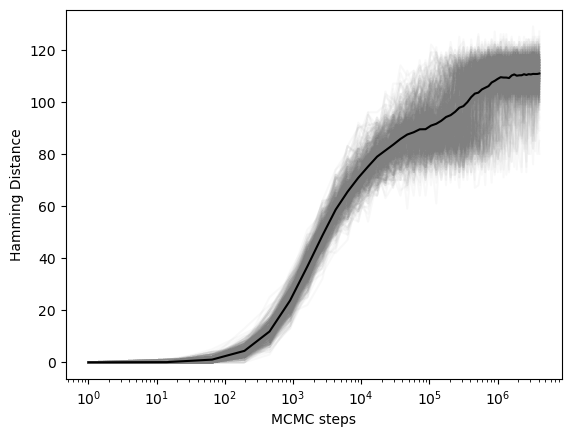

In [71]:
ham = hcat([count_muts_msa(x, step_matrices[1][1,:]) for x in step_matrices]...)
steps = [1+100*(i-1) for i in 1:size(ham,2)]
for i in 1:500
    plt.plot(X, ham[i,:]', color = "grey", alpha = 0.05)
end
plt.plot(X, mean(ham, dims = 1)[:], color = "black")
plt.xscale("log")
plt.xlabel("MCMC steps")
plt.ylabel("Hamming Distance")
savefig("../hamming_hdfr.png")

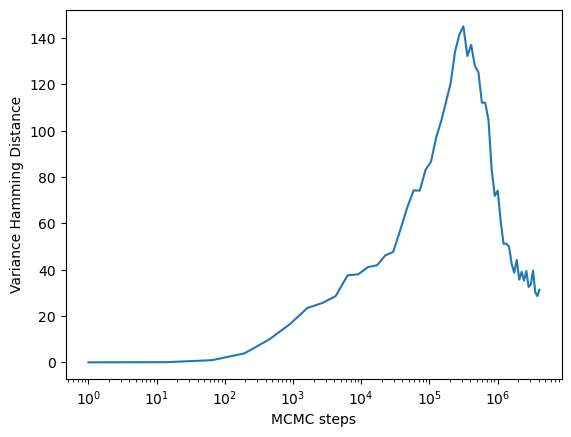

In [72]:
ham = hcat([count_muts_msa(x, step_matrices[1][1,:]) for x in step_matrices]...)
steps = [1+100*(i-1) for i in 1:size(ham,2)]

plt.plot(X, var(ham,dims = 1)[:])
plt.xscale("log")
plt.xlabel("MCMC steps")
plt.ylabel("Variance Hamming Distance")
savefig("../var_hamming_hdfr.png")

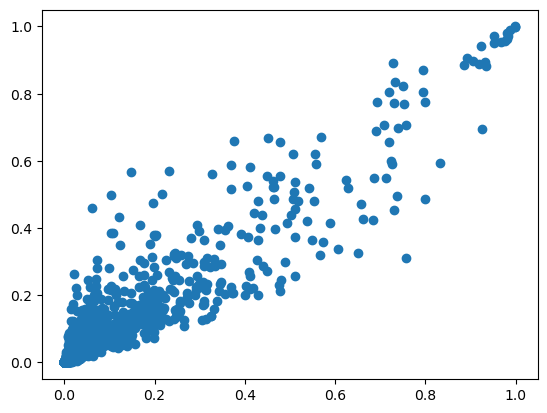

PyObject <matplotlib.collections.PathCollection object at 0x7f468f259970>

In [79]:
scatter(freqs_nat[:], freqs[end-25][:]) 

In [78]:
X[end-25]

410262

In [23]:
println("CIE")
println(round.(entr_nat, digits = 3))

CIE
[1.119, 1.973, 3.012, 2.463, 1.229, 2.009, 0.426, 3.214, 2.249, 3.264, 1.725, 2.65, 2.363, 0.453, 0.109, 3.156, 2.567, 1.422, 3.344, 1.295, 1.281, 0.807, 2.334, 1.338, 1.388, 2.987, 0.4, 1.646, 2.238, 2.483, 0.28, 1.367, 3.089, 3.027, 0.163, 3.161, 1.364, 2.516, 2.608, 1.748, 1.472, 0.664, 0.014, 0.549, 1.573, 0.499, 2.096, 1.871, 0.811, 1.913, 1.795, 2.079, 1.522, 0.256, 1.135, 2.07, 0.201, 3.377, 1.38, 1.474, 0.808, 1.75, 1.018, 1.696, 2.772, 3.677, 3.481, 3.124, 3.871, 3.445, 2.854, 1.739, 2.477, 3.489, 2.546, 2.577, 3.345, 1.668, 2.438, 2.742, 2.654, 1.454, 2.277, 3.316, 3.579, 2.932, 3.64, 3.665, 4.016, 3.187, 3.26, 2.513, 2.581, 2.484, 1.375, 1.528, 0.01, 0.011, 2.142, 2.87, 1.563, 0.86, 3.002, 2.749, 2.676, 1.892, 2.432, 3.561, 1.987, 2.454, 2.703, 1.993, 2.335, 2.029, 0.151, 3.199, 1.298, 2.844, 3.503, 3.387, 2.792, 2.811, 1.407, 0.415, 1.861, 2.667, 1.222, 0.795, 3.327, 2.725, 2.58, 3.952, 3.645, 3.547, 1.069, 3.483, 2.942, 3.017, 3.542, 3.247, 3.144, 3.843, 3.581, 3.866, 

In [24]:
println("CDE seq 1")
println(round.(cde_wt, digits = 3))

CDE seq 1
[0.016, 1.472, 0.396, 1.883, 0.251, 0.859, 0.084, 0.909, 0.62, 2.918, 0.782, 0.629, 0.048, 0.066, 0.025, 1.532, 1.734, 0.154, 2.958, 0.352, 0.029, 0.086, 1.882, 1.297, 1.401, 0.798, 0.308, 2.537, 1.351, 0.676, 0.579, 0.53, 2.074, 0.629, 0.53, 2.7, 1.108, 0.113, 1.64, 1.218, 0.283, 1.361, 0.001, 1.295, 1.48, 1.095, 0.288, 0.296, 1.18, 1.711, 0.241, 0.648, 0.123, 0.279, 1.127, 1.522, 0.386, 0.381, 0.227, 1.64, 0.964, 0.213, 0.451, 2.161, 1.131, 0.46, 2.426, 1.577, 1.966, 1.133, 3.041, 1.299, 0.921, 0.592, 0.345, 0.765, 2.37, 1.669, 1.809, 2.39, 2.26, 0.317, 1.108, 3.132, 2.232, 3.058, 2.963, 3.335, 3.061, 0.596, 0.394, 3.277, 1.406, 0.032, 0.805, 1.96, 0.002, 0.002, 0.693, 0.434, 1.143, 0.056, 0.517, 0.739, 1.561, 0.538, 2.555, 3.826, 2.71, 2.759, 1.176, 0.299, 0.18, 0.724, 0.017, 0.335, 0.456, 1.681, 1.852, 2.962, 0.714, 1.026, 1.047, 0.083, 1.055, 0.498, 1.182, 0.118, 1.358, 0.367, 1.371, 2.721, 2.9, 2.221, 0.647, 1.13, 0.403, 0.568, 0.904, 1.716, 2.76, 0.672, 3.156, 2.771, 2